In [1]:
# GST pipelines

# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=3264, height=2464, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_full.jpg
# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1920, height=1080, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_1080p.jpg
# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1280, height=720, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=test_720p.jpg

# gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=1 ! 'video/x-raw(memory:NVMM),width=1280, height=720, framerate=21/1, format=NV12' ! nvvidconv flip-method=2  ! 'video/x-raw,width=1440, height=1080' ! nvjpegenc ! filesink location=test_1080_4by3.jpg
# gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=UYVY ! videoscale ! video/x-raw,width=3264,height=2464 ! nvjpegenc ! filesink location=test_ir.jpg


# Functions to capture IR and RGB images


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


def get_ir_image():
    # save to png to preserve the 16 bit depth of IR image
    # !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY8 ! videoscale ! video/x-raw,width=800,height=600 ! videoconvert ! pngenc ! filesink location=/tmp/ir.png
    # !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY16_LE ! videoscale ! video/x-raw,width=800,height=600 ! videoconvert ! pngenc ! filesink location=/tmp/ir.png
    !gst-launch-1.0 v4l2src device=/dev/video1 num-buffers=1 ! video/x-raw,format=GRAY16_LE ! videoconvert ! pngenc ! filesink location=/tmp/ir.png

    return Image.open("/tmp/ir.png")

def get_rgb_image():
    !gst-launch-1.0 nvarguscamerasrc sensor_mode=0 num-buffers=15 ! 'video/x-raw(memory:NVMM),width=3264, height=2464, framerate=21/1, format=NV12' ! nvvidconv flip-method=2 ! nvjpegenc ! filesink location=/tmp/rgb.jpg
    return Image.open("/tmp/rgb.jpg")

def ktoc(val):
    # Kelvin to Celsius
    return (val - 27315) / 100.0

In [74]:
ir = get_ir_image()
rgb = get_rgb_image()

Setting pipeline to PAUSED ...
Pipeline is live and does not need PREROLL ...
Setting pipeline to PLAYING ...
New clock: GstSystemClock
Got EOS from element "pipeline0".
Execution ended after 0:00:00.526174765
Setting pipeline to PAUSED ...
Setting pipeline to READY ...
Setting pipeline to NULL ...
Freeing pipeline ...
Setting pipeline to PAUSED ...
Pipeline is live and does not need PREROLL ...
Setting pipeline to PLAYING ...
New clock: GstSystemClock
GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3264 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3264 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposur

# IR processing

- We get 122x160 array
- 120 horizontal lines contain the image.
- 2 horizontal lines will contain telemetry data.

For more info refer to:
https://www.flir.com/globalassets/imported-assets/document/flir-lepton-engineering-datasheet.pdf

In [75]:
ir.size # should be 160x122 pixels

(160, 122)

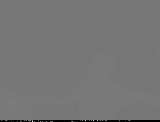

In [76]:
# Raw IR footage won't look like much
ir

In [119]:
ir_arr = np.array(ir) 
ir_arr = ir_arr[:-2, :] # trim the 2 bottom lines (telemetry)
ir_arr = ktoc(ir_arr) # Convert to Celsius
ir_arr_big = cv2.resize(ir_arr, (1024, 768)) # upscale

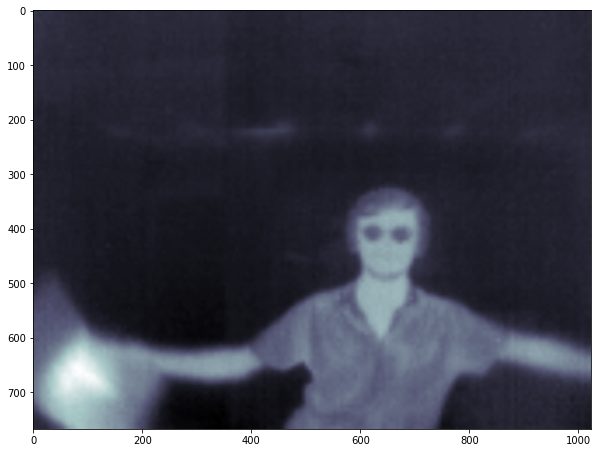

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(ir_arr_big, cmap='bone')

## We can see temeperatures of each pixel (in deg. C)

In [109]:
ir_arr

array([[32.56, 32.32, 32.36, ..., 31.93, 31.47, 31.77],
       [32.52, 32.06, 32.  , ..., 31.77, 31.47, 31.81],
       [32.38, 32.36, 32.24, ..., 31.57, 31.53, 31.77],
       ...,
       [31.77, 31.75, 32.32, ..., 31.11, 31.15, 30.81],
       [31.75, 31.57, 32.12, ..., 31.03, 30.71, 30.89],
       [31.77, 31.59, 31.77, ..., 31.11, 30.71, 30.73]])

## We can extract humans from scene based on a temperature threshold

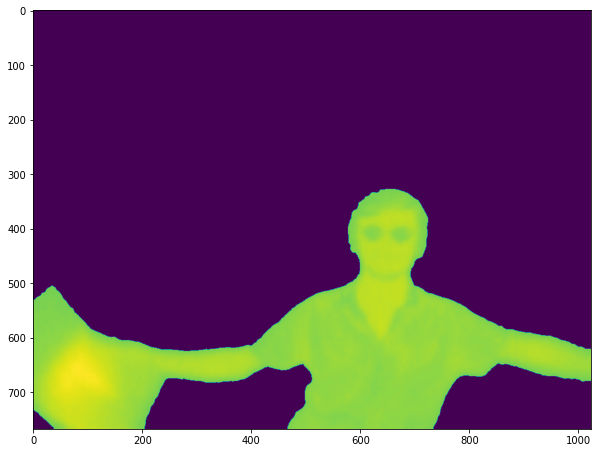

In [149]:
ir_arr_seg = ir_arr.copy()
ir_arr_seg = cv2.resize(ir_arr_seg, (1024, 768)) # upscale
ir_arr_seg[ir_arr_seg<33] = 0

plt.figure(figsize=(10,10))
plt.imshow(ir_arr_seg)

## Or measure the average temperature of the scene

In [107]:
ir_arr.mean() # Mean temperature of the scene

32.213230208333336

# RGB processing

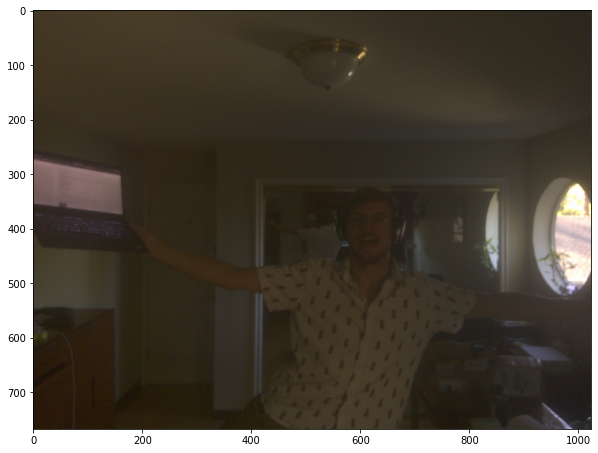

In [152]:
rgb_arr = np.array(rgb)
rgb_arr = cv2.resize(rgb_arr, (1024, 768))
plt.figure(figsize=(10,10))
plt.imshow(rgb_arr)

In [112]:
# # affine transform from triangles

# y, x = rgb_arr.shape
# cy, cx = y/2, x/2

# pts1 = np.float32([[cy-1,cx-1],[cy-1,cx+1],[cy+1,cx]])
# pts2 = np.float32([[cy-2,cx-2],[cy-2,cx+2],[cy+2,cx]])

# plt.scatter(pts1[:,0], pts1[:,1])
# plt.scatter(pts2[:,0], pts2[:,1])

# T = cv2.getAffineTransform(pts1,pts2)

# Let's visualize RGB and IR in one image

- RGB image is converted to grayscale and represented in red channel
- IR image is represented in green channel

As a result, the images are more or less aligned.
The alignment is very hacky, and could be improved.

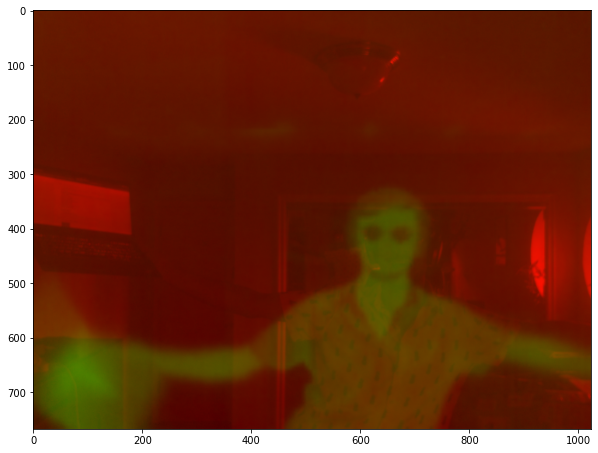

In [154]:
# Normalize deg. C to 0-255
ir_arr_normalized = cv2.normalize(ir_arr_big, None, 0, 255, cv2.NORM_MINMAX) 
ir_arr_normalized = ir_arr_normalized.astype(np.uint8)

T = np.array(
    [
        [1.1, 0.0, 0],
        [0.0, 1.1, 0]
    ])

gray_arr = cv2.cvtColor(rgb_arr, cv2.COLOR_BGR2GRAY)
gray_arr = cv2.warpAffine(gray_arr, T, tuple(reversed(gray_arr.shape)))

# rgb_arr_shifted = transform(rgb_arr, 300, 0, s=1.0)

to_show = np.stack([gray_arr+50, ir_arr_normalized//2, np.zeros_like(gray_arr)], axis=-1)

plt.figure(figsize=(10,10))
plt.imshow(to_show)

# Attempts at feature matching

I experimented with aligning the images via feature matching, but results were not great.

In [26]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()
# Find the keypoints and descriptors with SIFT
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)


In [33]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append([m])
        
# Draw matches
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('matches.jpg', img3)

True

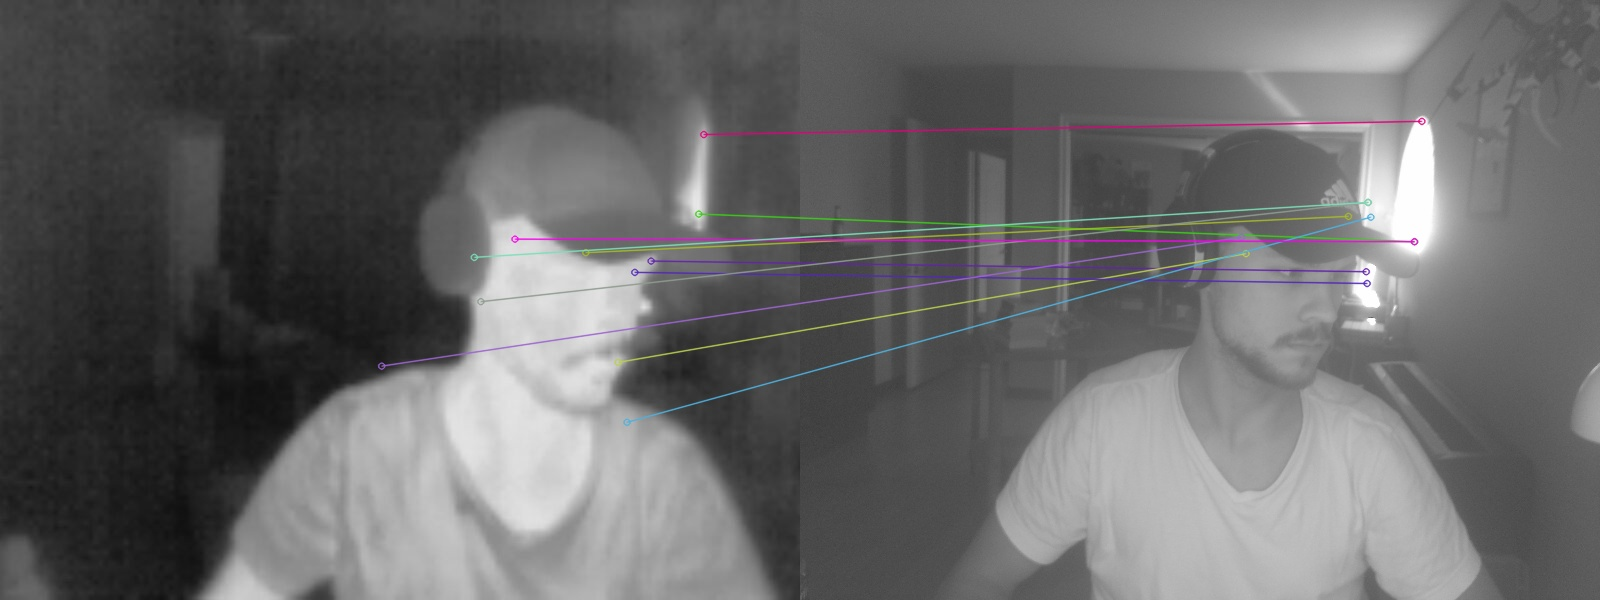

In [34]:
Image.open('matches.jpg')